![This is an image](Quant-Trading.jpg)

In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

In [2]:
#IMPORT EQUITY PRICES AND VIX
df = pd.read_csv('SPX.csv',encoding='UTF-8')   #IN THIS EXAMPLE WE USE SPX AND VIX
df_VIX = pd.read_csv('VIX.csv',encoding='UTF-8')   

In [3]:
#MERGE BOTH DATAFRAMES INTO A SINGLE ONE
df = pd.merge(df,df_VIX[['Date','Close']],left_on='Date',right_on='Date',how='left')
df = df.rename(columns={'Close_x': 'Close_SPX', 'Close_y': 'Close_VIX'})
df['Close_VIX'] = df['Close_VIX']/100

In [4]:
#CALCULATIONS USING LAMBDA FUNCTION - MUCH FASTER
df_is = df.iloc[0:7500]

stop_long = 0.7
stop_short = 1.2

NEW_HIGH = df_is['Close_SPX'].iloc[0]
NEW_LOW = df_is['Close_SPX'].iloc[0]
CLOSE_VIX = df_is['Close_VIX'].iloc[0]
PREVIOUS_SIGNAL = 1.0
SIGNAL = PREVIOUS_SIGNAL

def calculations(SIGNAL,CLOSE_SPX,CLOSE_VIX):
    global NEW_HIGH
    global NEW_LOW
    global PREVIOUS_SIGNAL    
    
    #COMPUTE SIGNAL, NEW_HIGH, NEW_LOW
    if PREVIOUS_SIGNAL == 1.0:
        if CLOSE_SPX < NEW_HIGH*(1-stop_long*CLOSE_VIX):            
            SIGNAL = -1.0            
            PREVIOUS_SIGNAL = 1.0
        else:            
            SIGNAL = 1.0
            PREVIOUS_SIGNAL = 1.0
    else:
        if CLOSE_SPX > NEW_LOW*(1+stop_short*CLOSE_VIX):            
            SIGNAL = 1.0
            PREVIOUS_SIGNAL = -1.0
        else:            
            SIGNAL = -1.0 
            PREVIOUS_SIGNAL = -1.0
            
    if SIGNAL!= PREVIOUS_SIGNAL:
        NEW_HIGH = CLOSE_SPX
        NEW_LOW = CLOSE_SPX
        PREVIOUS_SIGNAL = -1.0*PREVIOUS_SIGNAL
    else:
        if SIGNAL == 1.0:
            NEW_HIGH = np.maximum(NEW_HIGH,CLOSE_SPX)            
        else:
            NEW_LOW = np.minimum(NEW_LOW,CLOSE_SPX)           
            
    
    return SIGNAL, NEW_HIGH, NEW_LOW
            
                
results = df_is.apply(lambda row: calculations(SIGNAL, CLOSE_SPX=row['Close_SPX'],CLOSE_VIX=row['Close_VIX']),axis=1)

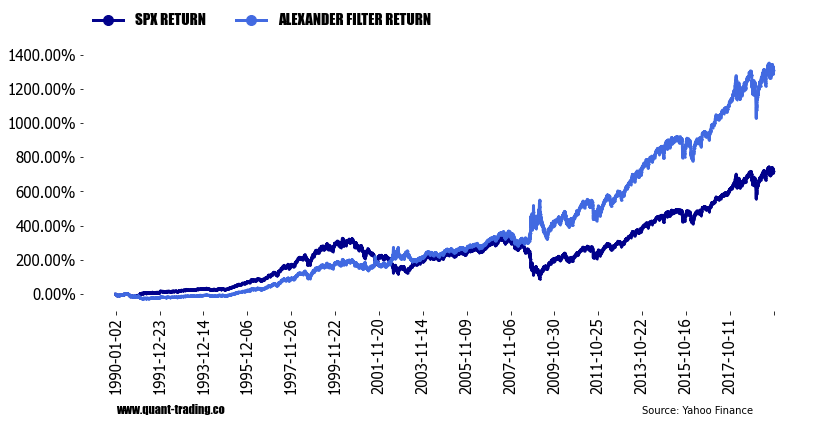

In [5]:
#CALCULATIONS

df_is['signal'] = [x[0] for x in results]
df_is['new_high'] = [x[1] for x in results]
df_is['new_low'] = [x[2] for x in results]

df_is['daily_return_mkt'] = df_is['Close_SPX'][1:].values/ df_is['Close_SPX'][:-1]-1
df_is['daily_return_mkt'] = df_is['daily_return_mkt'].shift(-1)
df_is['daily_return_signal'] = df_is['daily_return_mkt']*df_is['signal']

df_is['cumulative_return_mkt']=(1 + df_is['daily_return_mkt']).cumprod() - 1
df_is['cumulative_return_mkt'][1:]=df_is['cumulative_return_mkt'][:-1]
df_is['cumulative_return_signal']=(1 + df_is['daily_return_signal']).cumprod() - 1
df_is['cumulative_return_signal'][1:]=df_is['cumulative_return_signal'][:-1]

#------------------------CHART - SPX RETURNS VS ALEXANDER FILTER RETURNS-----------------------------------#
font = font_manager.FontProperties(family='Impact',weight='bold', style='normal', size=15)
tick_spacing1 = 500

fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(df_is['Date'],df_is['cumulative_return_mkt']*100,marker='o', linestyle='solid',linewidth=3,color='darkblue',alpha=0.99,label='SPX RETURN',markersize=1)
ax1.plot(df_is['Date'],df_is['cumulative_return_signal']*100,marker='o', linestyle='solid',linewidth=3,color='royalblue',alpha=0.99,label='ALEXANDER FILTER RETURN',markersize=1)
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.2),ncol=10,markerscale=10)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing1))
plt.xticks(rotation=90)
plt.yticks(fontname = "Tahoma",fontsize=15)
plt.xticks(fontname = "Tahoma",fontsize=15)
ax1.title.set_fontfamily('arial')
vals = ax1.get_yticks()
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
plt.box(on=None)

plt.text(df_is['Date'].iloc[-1500], -700,'Source: Yahoo Finance' , color='black', fontsize=10)
plt.text(df_is['Date'].iloc[-7500], -700,'www.quant-trading.co' , color='black', fontsize=12,family='Impact')

plt.subplots_adjust(bottom=0.1, right=1.8, top=1.0)

plt.show()

In [6]:
#FUNCTION DEFINITION FOR PARAMETER'S OPTIMIZATION
df_is = df.iloc[0:7500]
stop_long = 0.7
stop_short = 1.2

NEW_HIGH = df_is['Close_SPX'].iloc[0]
NEW_LOW = df_is['Close_SPX'].iloc[0]
CLOSE_VIX = df_is['Close_VIX'].iloc[0]
PREVIOUS_SIGNAL = 1.0
SIGNAL = PREVIOUS_SIGNAL

def function1(parameters):
    
    def calculations(SIGNAL,CLOSE_SPX,CLOSE_VIX):
        global NEW_HIGH
        global NEW_LOW
        global PREVIOUS_SIGNAL       


        #COMPUTE SIGNAL, NEW_HIGH, NEW_LOW
        if PREVIOUS_SIGNAL == 1.0:
            if CLOSE_SPX < NEW_HIGH*(1-parameters[0]*CLOSE_VIX):            
                SIGNAL = -1.0            
                PREVIOUS_SIGNAL = 1.0
            else:            
                SIGNAL = 1.0
                PREVIOUS_SIGNAL = 1.0
        else:
            if CLOSE_SPX > NEW_LOW*(1+parameters[1]*CLOSE_VIX):            
                SIGNAL = 1.0
                PREVIOUS_SIGNAL = -1.0
            else:            
                SIGNAL = -1.0 
                PREVIOUS_SIGNAL = -1.0

        if SIGNAL!= PREVIOUS_SIGNAL:
            NEW_HIGH = CLOSE_SPX
            NEW_LOW = CLOSE_SPX
            PREVIOUS_SIGNAL = -1.0*PREVIOUS_SIGNAL
        else:
            if SIGNAL == 1.0:
                NEW_HIGH = np.maximum(NEW_HIGH,CLOSE_SPX)            
            else:
                NEW_LOW = np.minimum(NEW_LOW,CLOSE_SPX)           


        return SIGNAL, NEW_HIGH, NEW_LOW
    
    
    df_is = df.iloc[0:7500]
    df_is['daily_return_mkt'] = df_is['Close_SPX'][1:].values/ df_is['Close_SPX'][:-1]-1
    df_is['daily_return_mkt'] = df_is['daily_return_mkt'].shift(-1)
    df_is['cumulative_return_mkt']=(1 + df_is['daily_return_mkt']).cumprod() - 1
    df_is['cumulative_return_mkt'][1:]=df_is['cumulative_return_mkt'][:-1]  
    
          
    results = df_is.apply(lambda row: calculations(SIGNAL, CLOSE_SPX=row['Close_SPX'],CLOSE_VIX=row['Close_VIX']),axis=1)
    df_is['signal'] = [x[0] for x in results]   
    df_is['daily_return_signal'] = df_is['daily_return_mkt']*df_is['signal']
    df_is['cumulative_return_signal']=(1 + df_is['daily_return_signal']).cumprod() - 1
    df_is['cumulative_return_signal'][1:]=df_is['cumulative_return_signal'][:-1]
    
    
    return -df_is['cumulative_return_signal'].iloc[-2]

In [7]:
#FUNCTION EVALUATION

function1([0.7,1.2])

-13.081935425495896

In [8]:
#OPTIMIZATION
df_is = df.iloc[0:7500]
stop_long = 0.7
stop_short = 1.2

NEW_HIGH = df_is['Close_SPX'].iloc[0]
NEW_LOW = df_is['Close_SPX'].iloc[0]
CLOSE_VIX = df_is['Close_VIX'].iloc[0]
PREVIOUS_SIGNAL = 1.0
SIGNAL = PREVIOUS_SIGNAL

from scipy.optimize.lbfgsb import fmin_l_bfgs_b
x0 = [0.8,1.2]
bounds=[[0.0,2.0],[0.0,2.0]]
xopt, optimizedF, infoDict = fmin_l_bfgs_b(function1,x0,bounds=bounds,approx_grad=True,epsilon=0.001)
print(xopt)
print(optimizedF)

[0.79199775 1.18799662]
-14.63519852776207


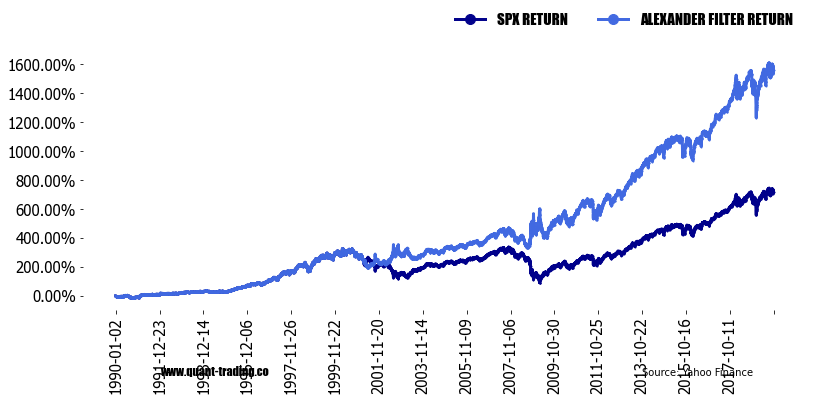

In [9]:
#OPTIMIZED PARAMETERS
df_is = df.iloc[0:7500]

stop_long = 0.792
stop_short = 1.188

NEW_HIGH = df_is['Close_SPX'].iloc[0]
NEW_LOW = df_is['Close_SPX'].iloc[0]
CLOSE_VIX = df_is['Close_VIX'].iloc[0]
PREVIOUS_SIGNAL = 1.0
SIGNAL = PREVIOUS_SIGNAL


df_is['daily_return_mkt'] = df_is['Close_SPX'][1:].values/ df_is['Close_SPX'][:-1]-1
df_is['daily_return_mkt'] = df_is['daily_return_mkt'].shift(-1)
df_is['cumulative_return_mkt']=(1 + df_is['daily_return_mkt']).cumprod() - 1
df_is['cumulative_return_mkt'][1:]=df_is['cumulative_return_mkt'][:-1]    
results = df_is.apply(lambda row: calculations(SIGNAL, CLOSE_SPX=row['Close_SPX'],CLOSE_VIX=row['Close_VIX']),axis=1)
df_is['signal'] = [x[0] for x in results]
df_is['daily_return_signal'] = df_is['daily_return_mkt']*df_is['signal']
df_is['cumulative_return_signal']=(1 + df_is['daily_return_signal']).cumprod() - 1
df_is['cumulative_return_signal'][1:]=df_is['cumulative_return_signal'][:-1] 

#------------------------CHART - SPX RETURNS VS ALEXANDER FILTER RETURNS-----------------------------------#
font = font_manager.FontProperties(family='Impact',weight='bold', style='normal', size=15)
tick_spacing1 = 500

fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(df_is['Date'],df_is['cumulative_return_mkt']*100,marker='o', linestyle='solid',linewidth=3,color='darkblue',alpha=0.99,label='SPX RETURN',markersize=1)
ax1.plot(df_is['Date'],df_is['cumulative_return_signal']*100,marker='o', linestyle='solid',linewidth=3,color='royalblue',alpha=0.99,label='ALEXANDER FILTER RETURN',markersize=1)
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(1.0, 1.2),ncol=10,markerscale=10)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing1))
plt.xticks(rotation=90)
plt.yticks(fontname = "Tahoma",fontsize=15)
plt.xticks(fontname = "Tahoma",fontsize=15)
ax1.title.set_fontfamily('arial')
vals = ax1.get_yticks()
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
plt.box(on=None)

plt.text(df_is['Date'].iloc[-1500], -550,'Source: Yahoo Finance' , color='black', fontsize=10)
plt.text(df_is['Date'].iloc[-7000], -550,'www.quant-trading.co' , color='black', fontsize=12,family='Impact')

plt.subplots_adjust(bottom=0.1, right=1.8, top=1.0)

plt.show()

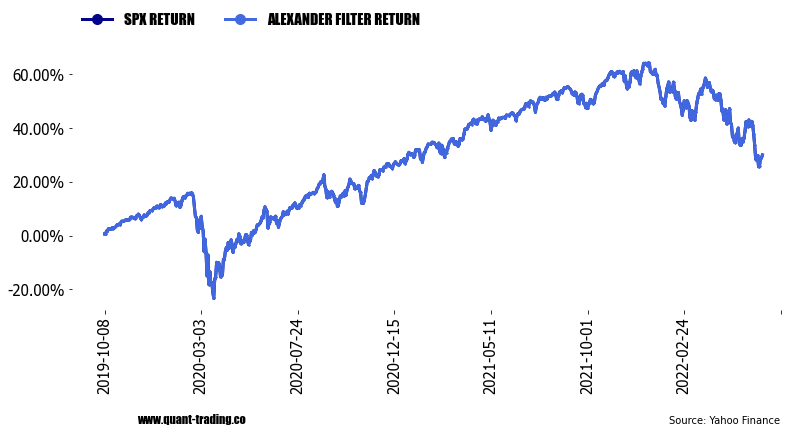

In [10]:
#OUT OF SAMPLE DATAFRAME

df_os = df.iloc[7500:8183]

stop_long = 0.792
stop_short = 1.188

NEW_HIGH = df_os['Close_SPX'].iloc[0]
NEW_LOW = df_os['Close_SPX'].iloc[0]
CLOSE_VIX = df_os['Close_VIX'].iloc[0]
PREVIOUS_SIGNAL = 1.0
SIGNAL = PREVIOUS_SIGNAL

results = df_os.apply(lambda row: calculations(SIGNAL, CLOSE_SPX=row['Close_SPX'],CLOSE_VIX=row['Close_VIX']),axis=1)
df_os['signal'] = [x[0] for x in results]


df_os['daily_return_mkt'] = df_os['Close_SPX'][1:].values/ df_os['Close_SPX'][:-1]-1
df_os['daily_return_mkt'] = df_os['daily_return_mkt'].shift(-1)
df_os['daily_return_signal'] = df_os['daily_return_mkt']*df_os['signal']
df_os['cumulative_return_mkt']=(1 + df_os['daily_return_mkt']).cumprod() - 1
df_os['cumulative_return_mkt'][1:]=df_os['cumulative_return_mkt'][:-1]
df_os['cumulative_return_signal']=(1 + df_os['daily_return_signal']).cumprod() - 1
df_os['cumulative_return_signal'][1:]=df_os['cumulative_return_signal'][:-1]

#------------------------CHART - SPX RETURNS VS ALEXANDER FILTER RETURNS-----------------------------------#
font = font_manager.FontProperties(family='Impact',weight='bold', style='normal', size=15)
tick_spacing1 = 100

fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(df_os['Date'],df_os['cumulative_return_mkt']*100,marker='o', linestyle='solid',linewidth=3,color='darkblue',alpha=0.99,label='SPX RETURN',markersize=1)
ax1.plot(df_os['Date'],df_os['cumulative_return_signal']*100,marker='o', linestyle='solid',linewidth=3,color='royalblue',alpha=0.99,label='ALEXANDER FILTER RETURN',markersize=1)
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.2),ncol=10,markerscale=10)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing1))
plt.xticks(rotation=90)
plt.yticks(fontname = "Tahoma",fontsize=15)
plt.xticks(fontname = "Tahoma",fontsize=15)
ax1.title.set_fontfamily('arial')
vals = ax1.get_yticks()
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
plt.box(on=None)

plt.text(df['Date'].iloc[-100], -70,'Source: Yahoo Finance' , color='black', fontsize=10)
plt.text(df['Date'].iloc[-650], -70,'www.quant-trading.co' , color='black', fontsize=12,family='Impact')

plt.subplots_adjust(bottom=0.1, right=1.8, top=1.0)

plt.show()